In [2]:
from __future__ import division, print_function
from concurrent.futures import ProcessPoolExecutor, wait
from matplotlib import pyplot as plt
from scipy import optimize as sco
import numpy as np
from tqdm import tqdm
import pandas as pd
import sys
import os

In [3]:
data_t0 = np.load('/fastio2/dasha/double_pulse/data_11vars_NuTau_1_1_1.npy',mmap_mode='r')
data_m0 = np.load('/fastio2/dasha/double_pulse/data_11vars_NuMu_1_1_1.npy',mmap_mode='r')
data_e0 = np.load('/fastio2/dasha/double_pulse/data_11vars_NuE_1_1_1.npy',mmap_mode='r')
data_c0 = np.load('/fastio2/dasha/double_pulse/data_Corsika_11057_11058_10670_trial.npy',mmap_mode='r')

In [4]:
maskl_t = data_t0['logan_veto']['SPE_rlogl']-data_t0['logan_veto']['Cascade_rlogl'] >-0.1
maskl_m = data_m0['logan_veto']['SPE_rlogl']-data_m0['logan_veto']['Cascade_rlogl'] >-0.1
maskl_e = data_e0['logan_veto']['SPE_rlogl']-data_e0['logan_veto']['Cascade_rlogl'] >-0.1
maskl_c = data_c0['logan_veto']['SPE_rlogl']-data_c0['logan_veto']['Cascade_rlogl'] >-0.1

#masks_t = (data_t0['preds']['n1'] >= 0.99) & (data_t0['preds']['n4'] >= 0.8)
#masks_m = (data_m0['preds']['n1'] >= 0.99) & (data_m0['preds']['n4'] >= 0.8)
#masks_e = (data_e0['preds']['n1'] >= 0.99) & (data_e0['preds']['n4'] >= 0.8)
#masks_c = (data_c0['preds']['n1'] >= 0.99) & (data_c0['preds']['n4'] >= 0.8)

mask_t = maskl_t #& masks_t
mask_m = maskl_m #& masks_m
mask_e = maskl_e #& masks_e
mask_c = maskl_c #& masks_c

data_t = data_t0[mask_t]
data_m = data_m0[mask_m]
data_e = data_e0[mask_e]
data_c = data_c0[mask_c]

print(data_t.shape,data_m.shape,data_e.shape,data_c.shape)
print(data_t.shape,data_m.shape,data_e.shape,data_c.shape)

(10769,) (8040,) (38307,) (41633,)
(10769,) (8040,) (38307,) (41633,)


In [5]:
masks_t = (data_t['preds']['n1'] >= 0.99) & (data_t['preds']['n4'] >= 0.8)
masks_m = (data_m['preds']['n1'] >= 0.99) & (data_m['preds']['n4'] >= 0.8)
masks_e = (data_e['preds']['n1'] >= 0.99) & (data_e['preds']['n4'] >= 0.8)
masks_c = (data_c['preds']['n1'] >= 0.99) & (data_c['preds']['n4'] >= 0.8)

maskb1_t = (data_t['preds']['n1'] <= 0.1) & (data_t['preds']['n4'] >= 0.8)
maskb1_m = (data_m['preds']['n1'] <= 0.1) & (data_m['preds']['n4'] >= 0.8)
maskb1_e = (data_e['preds']['n1'] <= 0.1) & (data_e['preds']['n4'] >= 0.8)
maskb1_c = (data_c['preds']['n1'] <= 0.1) & (data_c['preds']['n4'] >= 0.8)

maskb2_t = (data_t['preds']['n1'] >= 0.95) & (data_t['preds']['n4'] <= 0.3)
maskb2_m = (data_m['preds']['n1'] >= 0.95) & (data_m['preds']['n4'] <= 0.3)
maskb2_e = (data_e['preds']['n1'] >= 0.95) & (data_e['preds']['n4'] <= 0.3)
maskb2_c = (data_c['preds']['n1'] >= 0.95) & (data_c['preds']['n4'] <= 0.3)

maskb_t = maskb1_t | maskb2_t
maskb_m = maskb1_m | maskb2_m
maskb_e = maskb1_e | maskb2_e
maskb_c = maskb1_c | maskb2_c

sig = [sum(data_t['weight_val'][masks_t]), sum(data_m['weight_val'][masks_m])+sum(data_e['weight_val'][masks_e])+sum(data_c['weight_val'][masks_c])]
bkg = [sum(data_t['weight_val'][maskb_t]), sum(data_m['weight_val'][maskb_m])+sum(data_e['weight_val'][maskb_e])+sum(data_c['weight_val'][maskb_c])]
sig = np.array(sig)
bkg = np.array(bkg)

print(sig)
print(bkg)

[0.86152371 0.05009675]
[0.17206044 1.58528881]


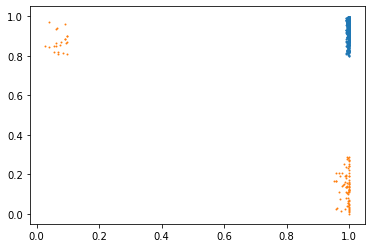

In [6]:
plt.scatter(data_t['preds']['n1'][masks_t],data_t['preds']['n4'][masks_t], s =0.9)
plt.scatter(data_t['preds']['n1'][maskb_t],data_t['preds']['n4'][maskb_t], s =0.9)

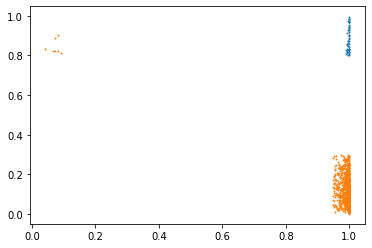

In [7]:
plt.scatter(data_m['preds']['n1'][masks_m],data_m['preds']['n4'][masks_m], s =0.9)
plt.scatter(data_m['preds']['n1'][maskb_m],data_m['preds']['n4'][maskb_m], s =0.9)

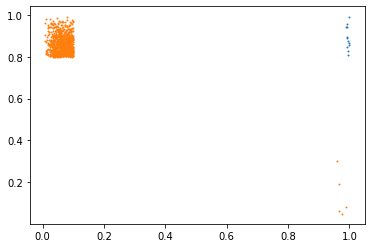

In [8]:
plt.scatter(data_e['preds']['n1'][masks_e],data_e['preds']['n4'][masks_e], s =0.9)
plt.scatter(data_e['preds']['n1'][maskb_e],data_e['preds']['n4'][maskb_e], s =0.9)

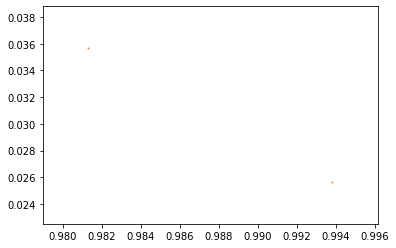

In [9]:
plt.scatter(data_c['preds']['n1'][masks_c],data_c['preds']['n4'][masks_c], s =0.9)
plt.scatter(data_c['preds']['n1'][maskb_c],data_c['preds']['n4'][maskb_c], s =0.9)

In [10]:
class BinnedPoissonLikelihood():
    '''
    Likelihood: Binned Poisson
    Model: P_B(x) + lmd_S * P_S(x)
    '''
    def __init__(self, sig_hist, bkg_hist, random_state):
        self.sig_hist = sig_hist
        self.bkg_hist = bkg_hist
        self.random_state = check_random_state(random_state)

    def log_likelihood(self, lmd, data_hist):
        expected_hist = (self.bkg_hist + lmd * self.sig_hist)
        result = np.sum(data_hist * np.log(expected_hist) - expected_hist)
        return -result

    def test_statistic(self, lmd, data_hist):
        expected_hist = (self.bkg_hist + lmd * self.sig_hist)
        null_hist = self.bkg_hist
        result = np.sum(data_hist * (np.log(expected_hist) -
                        np.log(null_hist)) - expected_hist + null_hist)
        return -result
    
    def test_statistic_best(self, lmd, true_lmd, data_hist):
        expected_hist = (self.bkg_hist + lmd * self.sig_hist)
        null_hist = (self.bkg_hist + true_lmd * self.sig_hist)
        result = np.sum(data_hist * (np.log(expected_hist) -
                        np.log(null_hist)) - expected_hist + null_hist)
        return -result
    
    def fit_lmd(self, data_hist):
        pars = [0.5]
        par_bounds = [(0, 100)]

        xmin, fmin, min_dict = sco.fmin_l_bfgs_b(
            func=self.test_statistic,
            x0=pars,
            bounds=par_bounds,
            args=(data_hist,),
            approx_grad=True
        )

        # set up mindict to enter while, exit if fit looks nice
        i = 1
        while min_dict["warnflag"] == 2 or b'FACTR' in min_dict["task"]:
            if i > 100:
                print("Did not manage good fit")
                print('results are {}, {}'.format(fmin, xmin))
                return fmin, xmin

            pars[0] = self.random_state.uniform(0., 1.)

            # no stop due to gradient
            xmin, fmin, min_dict = sco.fmin_l_bfgs_b(
                func=self.test_statistic,
                x0=pars,
                bounds=par_bounds,
                args=(data_hist,),
                approx_grad=True
            )
            i += 1

        return fmin, xmin
    
    def fit_lmd_best(self, true_lmd, data_hist):
        pars = [0.5]
        par_bounds = [(0, 100)]

        xmin, fmin, min_dict = sco.fmin_l_bfgs_b(
            func=self.test_statistic_best,
            x0=pars,
            bounds=par_bounds,
            args=(true_lmd, data_hist,),
            approx_grad=True
        )
        #print(xmin,fmin,min_dict)

        #print("min_dict1",min_dict)
        # set up mindict to enter while, exit if fit looks nice
        i = 1
        while min_dict["warnflag"] == 2 or b'FACTR' in min_dict["task"]:
            if i > 100:
                print("Did not manage good fit")
                print('results are {}, {}'.format(fmin, xmin))
                return fmin, xmin

            pars[0] = self.random_state.uniform(0., 1.)

            # no stop due to gradient
            xmin, fmin, min_dict = sco.fmin_l_bfgs_b(
                func=self.test_statistic_best,
                x0=pars,
                bounds=par_bounds,
                args=(true_lmd, data_hist,),
                approx_grad=True
            )
            #print(xmin,fmin,min_dict)
            #print("min_dict",min_dict)
            i += 1

        return fmin, xmin

In [11]:
def make_hists_and_exps(path, weight_col='weight', livetime=(3600 * 24 * 365 * 7)):
    #sig_df, bkg_df, sig_exp, bkg_exp = load_sample_and_combine_with_add_statistics(
    #        from_cache=True,
    #        cached_path=path,
    #        remove_muongun=False)
    sig_df = pd.read_csv(path+'sig_out.csv')
    #sig_exp = np.sum(sig)
    bkg_df = pd.read_csv(path+'bkg_out.csv')
    
    bins_x, bins_y = get_default_binning()

    sig, bkg, xe, ye = build_histograms(
        sig_df, bkg_df, bins_x, bins_y,
        #livetime=livetime, 
        density=False, weight_col=weight_col)

    sig_exp = np.sum(sig)
    bkg_exp = np.sum(bkg)

    del sig_df
    del bkg_df

    return sig, bkg, sig_exp, bkg_exp


def load_neyman_plane(folder='test_statistics'):
    file_names = glob(os.path.join(folder, '*.npz'))
    mus = np.asarray([float(fn.split('_')[-1].replace('.npz', '')) for fn in file_names])
    sort_idx = np.argsort(mus)
    ts_arrs = np.asarray([np.load(fn)['arr_0'] for fn in file_names])
    sorted_mus = mus[sort_idx]
    sorted_ts_arrs = ts_arrs[sort_idx]
    return sorted_mus, sorted_ts_arrs

In [12]:
#stats.py

def check_random_state(random_state):
    if isinstance(random_state, np.random.RandomState):
        return random_state
    else:
        if not isinstance(random_state, int):
            raise ValueError('random_state has to be either an int or of ' +
                             'type np.random.RandomState!')
        else:
            random_state = np.random.RandomState(random_state)
            return random_state
def sample_from_hist(hist, n_samples, random_state):
    '''Sample `n_samples` from a histogram and return them binned as a
    histogram in the same binning.
    Parameters
    ----------
    hist : ndarray
        Histogram to resample
    n_samples: int
        Number of samples to draw from the histogram
    Returns
    -------
    sampled_hist : ndarray
        Returns a histogram with the same shape of `hist` with `n_samples`
        entries.
    '''
    random_state = check_random_state(random_state)

    cdf = np.cumsum(hist)
    cdf = cdf / cdf[-1]
    #print('cdf',cdf,n_samples)
    values = random_state.rand(n_samples)
    #print('V',values)
    value_bins = np.searchsorted(cdf, values)
    #print('S',value_bins,hist.shape)  
    sampled_hist = np.bincount(value_bins, minlength=np.prod(hist.shape))
    #print('sh',sampled_hist)
    
    sampled_hist = sampled_hist.reshape(hist.shape)
    return sampled_hist

In [23]:
class SignalInjector(object):
    def __init__(self,
                 sig_dist, bkg_dist,
                 random_state,
                 sig_exp=None, bkg_exp=None):
        if sig_exp is not None:
            self.sig_exp = sig_exp
        else:
            self.sig_exp = np.sum(sig_dist)
        if bkg_exp is not None:
            self.bkg_exp = bkg_exp
        else:
            self.bkg_exp = np.sum(bkg_dist)

        self.sig_dist = sig_dist
        self.bkg_dist = bkg_dist
        self.random_state = check_random_state(random_state)
        
    def calc_n_events_per_trial(self, n_trials):
        n_sig_per_trial = self.random_state.poisson(lam=self.sig_exp, size=n_trials)
        n_bkg_per_trial = self.random_state.poisson(lam=self.bkg_exp, size=n_trials)
        return n_sig_per_trial, n_bkg_per_trial

    def create_samples(self):
        dists = [self.sig_dist, self.bkg_dist]
        n_samples = [self.n_sig_per_trial,
                     self.n_bkg_per_trial]
        
        samples_sig, samples_bkg = [], []
        for i, dist in enumerate(dists):
            for j in range(len(n_samples[i])):
                #print("AA",n_samples)
                sample = sample_from_hist(dist, n_samples[i][j], self.random_state)
                #print('sample',sample)
                if i == 0:
                    samples_sig.append(sample)
                elif i == 1:
                    samples_bkg.append(sample)
        self.sig_samples = samples_sig
        self.bkg_samples = samples_bkg
        #print(samples_sig, samples_bkg)
        return samples_sig, samples_bkg
    
    def return_samples(self, n_trials):
        self.n_sig_per_trial, self.n_bkg_per_trial = \
            self.calc_n_events_per_trial(n_trials)

        self.create_samples()
        return np.array(self.sig_samples) + np.array(self.bkg_samples)

    def do_trials(self, n_trials, llh):
        self.n_sig_per_trial, self.n_bkg_per_trial = \
            self.calc_n_events_per_trial(n_trials)
        #print("s",self.sig_dist)
        #print("bk",self.bkg_dist)
        #print("be",self.bkg_exp)
        
        #print("a",self.n_sig_per_trial)
        #print("b",self.n_bkg_per_trial)
        self.create_samples()
        #print("ss",self.sig_samples)
        #print("sb",self.bkg_samples)
        
        ts_vals = []
        lmds = []
        
        true_lmd = self.sig_exp / float(np.sum(self.sig_dist))
        #print("true lmd", true_lmd, self.sig_exp,float(np.sum(self.sig_dist)))
        
        for i in range(n_trials):
        #for i in tqdm(range(n_trials)):
            samples = (self.sig_samples[i] + self.bkg_samples[i])

            ts, lmd = llh.fit_lmd_best(true_lmd, samples)
            ts_vals.append(-ts)
            lmds.extend(lmd)
        # print(np.mean(lmds), np.median(lmds))
        return ts_vals, lmds

In [24]:
def scan_neyman_row(sig_inj, n_samples, likelihood, mu):
    sig_ts,_ = sig_inj.do_trials(
        n_samples, likelihood)
    sig_ts = np.array(sig_ts)
    #lmd = np.array(lmd)
    sig_ts[sig_ts < 0] = 0
    #print(sig_ts, mu)
    return sig_ts, mu

def scan_neyman_plane(sig, bkg, bkg_exp,
                      mu_bins, ts_bins, n_samples_per_mu,
                      n_jobs=1, save=False, out_path=None):
    def save_stuff(out_path, hist, mu):
        if out_path is not None:
            out_path1 = os.path.join(
                out_path, 'ts_mu_{}.npz'.format(mu_i))
            np.savez(out_path1, hist)
            #out_path2 = os.path.join(
            #    out_path, 'lmd_mu_{}.npz'.format(mu_i))
            #np.savez(out_path2, lmd)

    if not save:
        hists = np.zeros((len(mu_bins), len(ts_bins) - 1))
        
    random_state = np.random.RandomState(42)
    likelihood = BinnedPoissonLikelihood(sig, bkg, random_state=random_state)

    if n_jobs > 1:
        with ProcessPoolExecutor(max_workers=n_jobs) as executor:
            futures = []
            for i, mu_i in enumerate(mu_bins):
                injector_rs = np.random.RandomState(i)
                #print('S',sig, bkg, bkg_exp)
                sig_inj = SignalInjector(sig, bkg, injector_rs, sig_exp=mu_i, bkg_exp=bkg_exp)
                futures.append(
                    executor.submit(
                        scan_neyman_row,
                        sig_inj=sig_inj,
                        n_samples=n_samples_per_mu,
                        likelihood=likelihood,
                        mu=mu_i))
            results = wait(futures)
            #print(results)
        for i, future_i in enumerate(results.done):
            try:
                sig_ts, mu_i = future_i.result()
            except Exception as exc:
                print('%r generated an exception: %s' % (future_i, exc))
            idx = np.where(mu_bins == mu_i)[0][0]
            hist, ts_e = np.histogram(sig_ts, bins=ts_bins)
            hist = hist / float(np.sum(hist))
            if not save:
                hists[idx] = hist
            else:
                save_stuff(out_path, sig_ts, mu_i)

    else:
        #raise NotImplementedError('Adapt to new implementation!')
        for i, mu_i in tqdm(enumerate(mu_bins)):
            injector_rs = np.random.RandomState(i)
            sig_inj = SignalInjector(sig, bkg, injector_rs, sig_exp=mu_i, bkg_exp=bkg_exp)
            sig_ts, mu_i = scan_neyman_row(sig_inj=sig_inj,n_samples=n_samples_per_mu, likelihood=likelihood,mu=mu_i)
            sig_ts = np.array(sig_ts)
            sig_ts[sig_ts < 0] = 0
            hist, ts_e = np.histogram(sig_ts, bins=ts_bins)
            hist = hist / float(np.sum(hist))
            if not save:
                hists[i] = hist
            else:
                save_stuff(out_path, sig_ts, mu_i)

    if not save:
        return hists, ts_e
    else:
        return 0, 0

In [25]:
n_jobs=20
n_samples=1000
mu_bins = np.linspace(0, 50, 801)
ts_bins = np.linspace(0, 20, 201)
def main(n_jobs, n_samples):
    global mu_bins,ts_bins
    sig_exp, bkg_exp = np.sum(sig), np.sum(bkg) 
    
    print(sig,sig.shape)
    print(bkg)
    print(sig_exp, bkg_exp)
    
    ts_bins = ts_bins - np.diff(ts_bins)[0] / 2.
    n_samples_per_mu = n_samples
    out_path ="/home/dup193/work/double_pulse/twobin_test/ts_dist/"
    if not os.path.isdir(out_path):
        os.makedirs(out_path)
    hists, ts_e = scan_neyman_plane(
        sig, bkg, bkg_exp,
        mu_bins, ts_bins, n_samples_per_mu,
        n_jobs=n_jobs, save=True,
        out_path=out_path)


if __name__ == '__main__':
    main(n_jobs,n_samples)

[0.86152371 0.05009675] (2,)
[0.17206044 1.58528881]
0.9116204624751845 1.7573492527609673


In [26]:
from glob import glob
import re
name_out = "/home/dup193/work/double_pulse/twobin_test/ts_dist/"
mat = []
hists = np.zeros((len(mu_bins), len(ts_bins) - 1))
for file_name in glob(name_out+'*'):
    sp = re.split('_|\.|/',file_name)
    mu = float(sp[-3]+"."+sp[-2])
    i = np.where(mu_bins==mu)
    x = np.load(file_name, mmap_mode="r")['arr_0']
    #print(x)
    hist, ts_e = np.histogram(x, bins=ts_bins)
    hist = hist / float(np.sum(hist))
    hists[i] = hist
#print(mat[0].shape)
#for i in mat:
#    print(i.shape)
#mat = np.stack(mat, axis=0)
#mat = mat.reshape(mat.shape[0],mat[0].shape[0])

In [27]:
print(sum(hists))
#print(mat.shape)

[1.95899e+02 1.34265e+02 8.38300e+01 6.15070e+01 4.86150e+01 3.89300e+01
 3.18710e+01 2.70280e+01 2.30780e+01 1.95060e+01 1.68040e+01 1.43840e+01
 1.25030e+01 1.09250e+01 9.52000e+00 8.29900e+00 7.34600e+00 6.38500e+00
 5.70600e+00 5.01700e+00 4.30700e+00 3.90400e+00 3.52300e+00 2.99700e+00
 2.61100e+00 2.37800e+00 2.11900e+00 1.87500e+00 1.78800e+00 1.48400e+00
 1.35600e+00 1.19900e+00 1.08700e+00 9.61000e-01 9.06000e-01 7.25000e-01
 6.98000e-01 6.31000e-01 5.26000e-01 5.03000e-01 3.77000e-01 3.85000e-01
 3.08000e-01 2.96000e-01 2.75000e-01 2.37000e-01 2.06000e-01 1.95000e-01
 1.55000e-01 1.64000e-01 1.36000e-01 1.29000e-01 9.50000e-02 9.50000e-02
 9.20000e-02 9.80000e-02 7.50000e-02 6.60000e-02 6.80000e-02 6.60000e-02
 3.90000e-02 5.20000e-02 5.20000e-02 3.40000e-02 3.60000e-02 3.60000e-02
 2.50000e-02 2.70000e-02 2.20000e-02 1.60000e-02 1.80000e-02 9.00000e-03
 9.00000e-03 1.00000e-02 1.20000e-02 1.00000e-02 1.20000e-02 5.00000e-03
 7.00000e-03 8.00000e-03 7.00000e-03 0.00000e+00 4.

/home/dup193/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


Text(0, 0.5, 'Mean signal expectation $\\mu_t$')

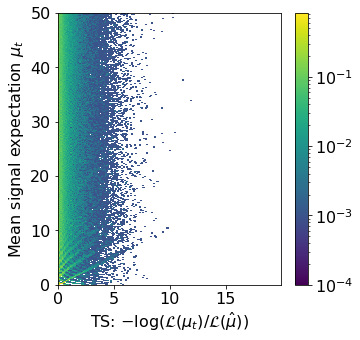

In [28]:
from matplotlib.colors import LogNorm
vmin = np.min([np.min(hist) for hist in hists])
vmax = np.max([np.max(hist) for hist in hists])
fig = plt.figure(figsize=(5, 5),facecolor ='w')
plt.rcParams.update({'font.size': 16})
plt.ticklabel_format(axis='both', style='sci', scilimits=(-5,5))
ax = fig.add_subplot()
for i in range(len(mu_bins) - 1):
    Xe, Ye = np.meshgrid(ts_bins, [mu_bins[i], mu_bins[i+1]])
    im = ax.pcolormesh(Xe, Ye, np.atleast_2d(hists[i]), vmin=vmin+1e-4, vmax=vmax, norm=LogNorm())
plt.colorbar(im)
ax.set_xlabel('TS: $-\log(\mathcal{L}(\mu_t) / \mathcal{L}(\hat{\mu}))$')
ax.set_ylabel(r'Mean signal expectation $\mu_t$')
# plt.savefig('plots/neyman_plane_hans.pdf', bbox_inches='tight')
#ax.imshow(hists,origin='lower',interpolation='none', extent=[0,20,0,20])

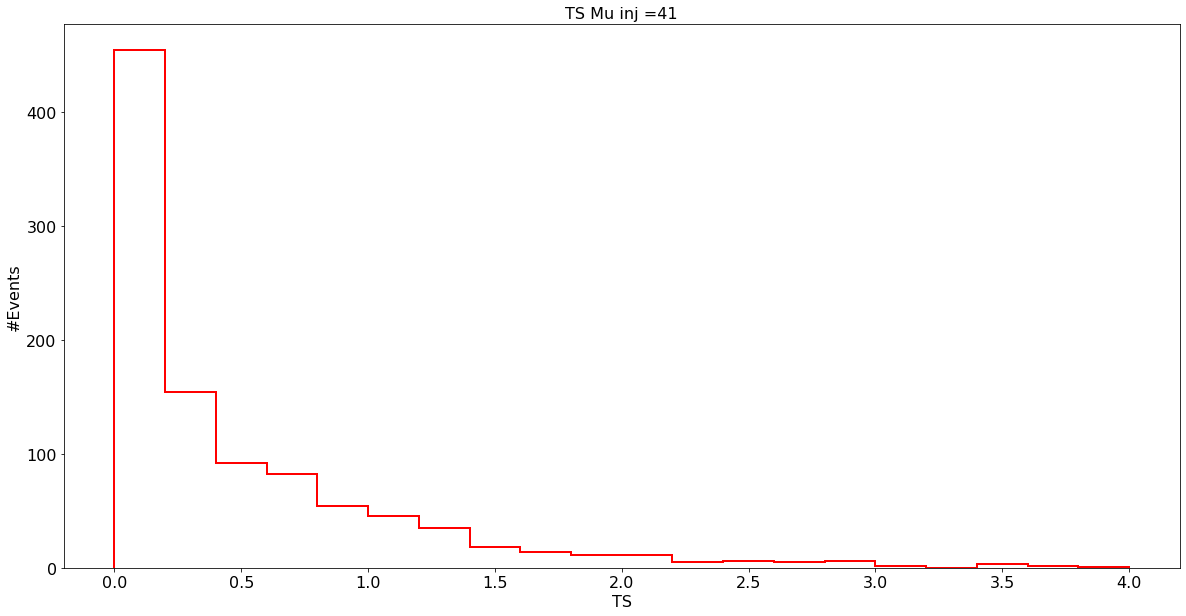

In [29]:
from glob import glob
import re 
file_name = "/home/dup193/work/double_pulse/twobin_test/ts_dist/ts_mu_41.0.npz"
x = np.load(file_name, mmap_mode="r")['arr_0']
fig = plt.figure(figsize=(20, 10),facecolor ='w')
ax = fig.add_subplot(111)
plt.rcParams.update({'font.size': 16})
plt.ticklabel_format(axis='both', style='sci', scilimits=(-5,5))
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_title("TS Mu inj =41", fontsize = 16)
ax.set_xlabel("TS", fontsize = 16)                                                              
ax.set_ylabel("#Events", fontsize = 16)                                                   
ax.hist(x, bins = 20, histtype = 'step',edgecolor ='r', lw =2, range =[0,4], label = "NuTauCC")  
#plt.legend(loc=loc)
plt.show()


In [18]:
def get_acc_vals_from_ts_vals(tss, alpha=0.9):
    acc_vals = np.zeros(tss.shape[0])
    n_samples = tss.shape[1]
    for i, row in enumerate(tss):
        critical_val = np.quantile(row, alpha)
        acc_vals[i] = critical_val

    return acc_vals


def calc_limits_from_trials(likelihood, bkg_samples, mus, acceptance_values, signal_expectation):
    lower_limits = []
    upper_limits = []

    for i in tqdm(range(len(bkg_samples))):
        accepted_mus = np.zeros_like(mus, dtype=int)
        ts, lmd_bf = likelihood.fit_lmd(bkg_samples[i])
        for j, mu in enumerate(mus):
            lmd = mu / signal_expectation
            bf_ts = likelihood.test_statistic_best(lmd_bf, lmd, bkg_samples[i])

            if acceptance_values[j] >= (-bf_ts):
                accepted_mus[j] = 1

        accepted_mu_mask = np.array(accepted_mus, dtype=bool)
        lower_limit = np.min(mus[accepted_mu_mask])
        upper_limit = np.max(mus[accepted_mu_mask])
        lower_limits.append(lower_limit)
        upper_limits.append(upper_limit)
    return np.array(lower_limits), np.array(upper_limits)


class LimitCalculator(object):
    def __init__(self, name, flux_systematic,
                 scan_path, df_path=None,
                 livetime=(3600 * 24 * 365 * 7),
                 random_state=1234,
                 alpha=0.9):
        self.name = name
        self.scan_path = scan_path
        self.flux_systematic = flux_systematic
        self.random_state = np.random.RandomState(random_state)
        self.livetime = livetime
        self.alpha = alpha

        if flux_systematic is True:
            #self.df_path = os.path.join(
            #    '/net/nfshome/home/mmeier/level5/loading/',
            #    'cached_dfs_aachen8yr_muongun_add_numu.hd5')
            if df_path is None:
                self.df_path = os.path.join(
                    '/net/nfshome/home/mmeier/level5/loading/',
                    'cached_dfs_aachen8yr_livetime.hd5')
            else:
                self.df_path = df_path
        else:
            self.df_path = os.path.join(
                '/home/dup193/work/double_pulse/max_test/dataframes/')
                #'cached_{}.hd5'.format(self.name))

        self.__load_acceptance_values__()
        self.__load_hists_and_exps__()

    def __load_acceptance_values__(self, return_ts=False):
        mus, tss = load_neyman_plane(self.scan_path)
        self.mus = mus
        self.acc_vals = get_acc_vals_from_ts_vals(tss, alpha=self.alpha)
        if return_ts:
            return tss
        else:
            del tss

    def __load_hists_and_exps__(self):
        if self.flux_systematic:
            if self.name.lower() == 'baseline':
                weight_col = 'weight'
            else:
                splitted_sys = np.append(['Weight_'], self.name.split('_'))
                weight_col = ''.join([split_i.capitalize() for split_i in splitted_sys])
        else:
            weight_col = 'weight'

        sig, bkg, sig_exp, bkg_exp = make_hists_and_exps(
            self.df_path, weight_col, self.livetime)
        self.sig, self.bkg = sig, bkg
        self.sig_exp, self.bkg_exp = sig_exp, bkg_exp

    def set_likelihood(self, likelihood):
        self.likelihood = likelihood

    def create_samples(self, n_samples=1000, bkg_only=True, sig_inj=None):
        if bkg_only and sig_inj is not None:
            raise ValueError('Samples can be either background only or ' +
                             'have a fixed amount of signal events injected!')
        if bkg_only:
            sig_inj = SignalInjector(self.sig, self.bkg,
                                     random_state=self.random_state,
                                     sig_exp=0.)
        elif sig_inj is not None:
            sig_inj = SignalInjector(self.sig, self.bkg,
                                     random_state=self.random_state,
                                     sig_exp=sig_inj)
        else:
            raise ValueError('Either use the bkg_only option or supply ' +
                             'an expected amount of signal!')

        self.samples = sig_inj.return_samples(n_samples)
        self.injected_signal = sig_inj.sig_exp
        return self.samples

    def calculate_limits(self, acc_vals, flux_norm, samples=None):
        if samples is None:
            samples = self.samples
        sig_exp = np.sum(self.likelihood.sig_hist)
        self.lower_limits, self.upper_limits = calc_limits_from_trials(
            self.likelihood, samples, self.mus, acc_vals, sig_exp)

        self.lower_limits_flux = self.lower_limits / sig_exp * flux_norm
        self.upper_limits_flux = self.upper_limits / sig_exp * flux_norm

    def check_coverage(self):
        n_samples_covered = np.sum(np.logical_and(
            self.lower_limits <= self.injected_signal,
            self.upper_limits >= self.injected_signal))
        n_samples_total = len(self.lower_limits)
        return n_samples_covered / n_samples_total

    @property
    def average_upper_limit(self):
        return np.mean(self.upper_limits_flux)

    @property
    def average_lower_limit(self):
        return np.mean(self.lower_limits_flux)

In [19]:
limit_calculator = LimitCalculator(
    'baseline', flux_systematic=False,
     scan_path='/home/dup193/work/double_pulse/max_test/ts_dist/',
     df_path='/home/dup193/work/double_pulse/max_test/dataframes/',
     livetime=1)

In [20]:
likelihood = BinnedPoissonLikelihood(limit_calculator.sig, limit_calculator.bkg, limit_calculator.random_state)
limit_calculator.set_likelihood(likelihood)

In [21]:
tss = limit_calculator.__load_acceptance_values__(return_ts=True)

In [22]:
mus = limit_calculator.mus

In [23]:
ts_bins = np.linspace(0, 20, 501)
ts_bins = ts_bins - np.diff(ts_bins)[0] / 2.
hists = []
for i in range(len(mus)):
    hist_i, edges = np.histogram(tss[i], bins=ts_bins, density=False)
    hist_i = hist_i / float(np.sum(hist_i))
    hists.append(hist_i)

Text(0.5, 0, 'TS')

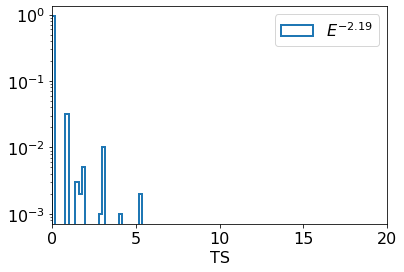

In [24]:
ts_center = (ts_bins[1:] + ts_bins[:-1]) / 2.
plt.hist(ts_center, bins=ts_bins[::5],
         weights=hists[0],
         histtype='step', lw=2,
         label='$E^{-2.19}$')
plt.yscale('log')
plt.xlim(0, 20)
plt.legend()
plt.xlabel('TS')

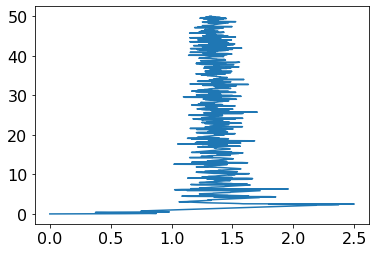

In [25]:
plt.plot(limit_calculator.acc_vals, mus)

Text(0.5, 0, 'TS')

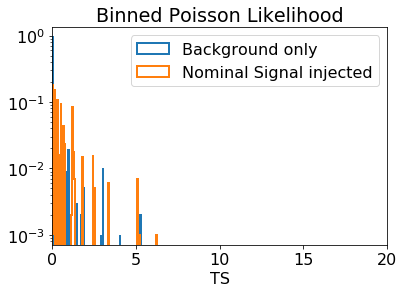

In [26]:
ts_center = (ts_bins[1:] + ts_bins[:-1]) / 2.
plt.title('Binned Poisson Likelihood')
plt.hist(ts_center, bins=ts_bins,
         weights=hists[0],
         histtype='step', lw=2,
         label='Background only')
plt.hist(ts_center, bins=ts_bins,
         weights=hists[81],
         histtype='step', lw=2,
         label='Nominal Signal injected')
plt.yscale('log')
plt.xlim(0, 20)
plt.legend()
plt.xlabel('TS')

No handles with labels found to put in legend.


Text(0.5, 0, 'TS')

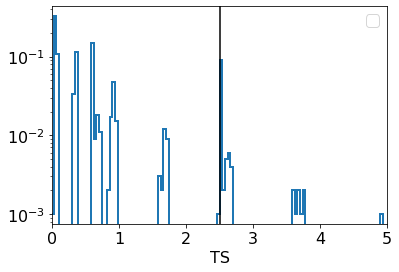

In [27]:
idx = 40
plt.hist(ts_center, bins=ts_bins,
         weights=hists[idx],
         histtype='step', lw=2)
plt.axvline(limit_calculator.acc_vals[idx], color='k')
plt.yscale('log')
plt.xlim(0, 5)
plt.legend()
plt.xlabel('TS')

In [28]:
samples_bkg = limit_calculator.create_samples()

In [29]:
lmds = np.linspace(0, 30, 301)

llh_vals = []
for lmdi in lmds:
    llh_val = likelihood.log_likelihood(lmdi, samples_bkg[7])
    llh_vals.append(llh_val)

ts_vals = []
for lmdi in lmds:
    _, lmd = likelihood.fit_lmd_best(lmdi, samples_bkg[7])
    ts_val = likelihood.test_statistic_best(
        lmd, lmdi, samples_bkg[7])
    ts_vals.append(-ts_val)

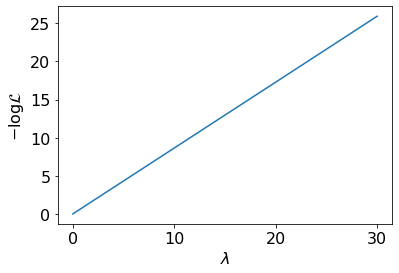

In [30]:
plt.plot(lmds, llh_vals)
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$-\log \mathcal{L}$');

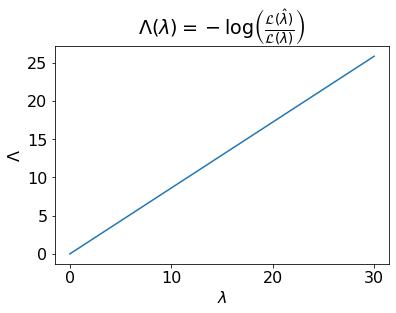

In [31]:
plt.plot(lmds, ts_vals)
plt.title(r'$\Lambda(\lambda) = - \log \left(\frac{\mathcal{L}(\hat{\lambda})}{\mathcal{L}(\lambda)} \right)$')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\Lambda$');

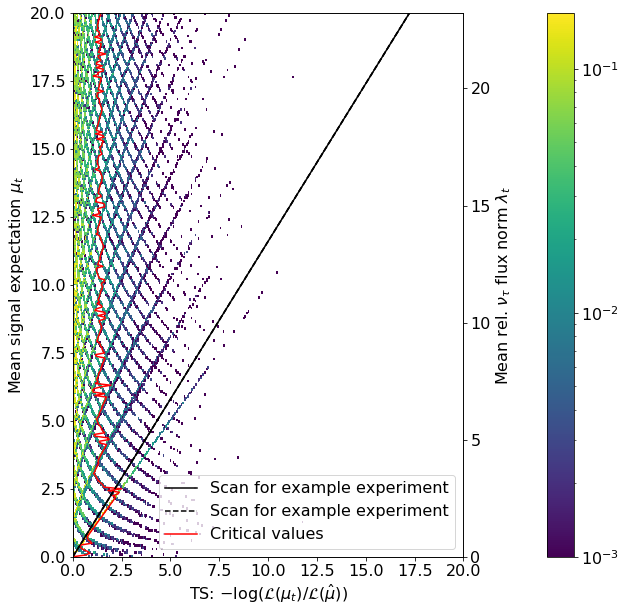

In [32]:
vmin = np.min([np.min(hist) for hist in hists])
vmax = np.max([np.max(hist) for hist in hists])

ts_vals = []
for mu in mus:
    lmd = mu / limit_calculator.sig_exp
    ts_val, lmd = likelihood.fit_lmd_best(mu, samples_bkg[81])
    ts_vals.append(-ts_val)
    
ts_vals2 = []
for mu in mus:
    lmd = mu / limit_calculator.sig_exp
    ts_val, lmd = likelihood.fit_lmd_best(mu, samples_bkg[0])
    ts_vals2.append(-ts_val)

fig, ax = plt.subplots(figsize=(10, 10),facecolor ='w')
for i in range(len(mus) - 1):
    Xe, Ye = np.meshgrid(ts_bins, [mus[i], mus[i+1]])
    im = ax.pcolormesh(Xe, Ye, np.atleast_2d(hists[i]), norm=LogNorm())# , vmin=vmin+1e-4, vmax=vmax
plt.plot(ts_vals, mus, color='k', label='Scan for example experiment')
plt.plot(ts_vals2, mus, color='k', ls='--', label='Scan for example experiment')
plt.plot(limit_calculator.acc_vals, mus, color='r', label='Critical values')
ax.set_xlabel('TS: $-\log(\mathcal{L}(\mu_t) / \mathcal{L}(\hat{\mu}))$')
ax.set_ylabel(r'Mean signal expectation $\mu_t$')
plt.xlim(0, 20)
ylim_lower = 0
ylim_upper = 20
plt.ylim(ylim_lower, ylim_upper)
plt.legend()
ax2 = ax.twinx()
ax2.set_ylabel(r'Mean rel. $\nu_{\tau}$ flux norm $\lambda_t$')
ax2.plot(ts_vals2, mus/limit_calculator.sig_exp, color='k', ls='--', label='Scan for example experiment')
ax2.set_ylim(ylim_lower/limit_calculator.sig_exp, ylim_upper/limit_calculator.sig_exp)
plt.colorbar(im, pad=0.15)

In [33]:
flux_norm = 2.46
limit_calculator.calculate_limits(limit_calculator.acc_vals, flux_norm)

100%|██████████| 1000/1000 [00:14<00:00, 67.81it/s]


In [34]:
limit_calculator.average_upper_limit

7.307340957102156

Text(0.5, 1.0, 'Fitting with $E^{-2.5}$')

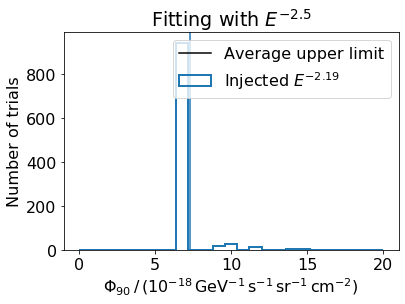

In [36]:
ul_bins = np.linspace(0, 20, 26)
plt.hist(limit_calculator.upper_limits_flux, bins=ul_bins, histtype='step', lw=2, label='Injected $E^{-2.19}$')
plt.axvline(limit_calculator.average_upper_limit)
plt.plot([], [], color='k', ls='-', label='Average upper limit')
plt.legend()
plt.xlabel('$\Phi_{90} \, / \, (10^{-18} \, \mathrm{GeV}^{-1} \, \mathrm{s}^{-1} \, \mathrm{sr}^{-1} \, \mathrm{cm}^{-2})$')
plt.ylabel('Number of trials')
plt.title('Fitting with $E^{-2.5}$')